# Setup

In [1]:
!pip install --upgrade --force-reinstall --no-deps --quiet kaggle

     |████████████████████████████████| 58 kB 3.2 MB/s 


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c tensorflow-great-barrier-reef -p /content/starfish

100% 14.2G/14.2G [03:22<00:00, 88.9MB/s]
100% 14.2G/14.2G [03:22<00:00, 75.2MB/s]


In [4]:
!unzip -q /content/starfish/*.zip -d /content/starfish/

In [5]:
!rm /content/starfish/*.zip

# Dataset

In [161]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json

In [162]:
!ls /content/starfish

example_sample_submission.csv  greatbarrierreef  train.csv
example_test.npy	       test.csv		 train_images


In [163]:
train_df = pd.read_csv('/content/starfish/train.csv')

In [164]:
#img_sizes = []
#c = 0
#for fpath in image_filepaths:
#    img_size = keras.preprocessing.image.load_img(fpath).size
#    img_sizes.append(img_size)
#    c += 1
#    if c % 1000 == 0:
#        print(f"{c}/{len(image_filepaths)}")

# ALL IMAGES (1280, 720) - (W, H)

In [165]:
# 
# Get image dataset
#
# Note: Class = video_id
train_images_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/starfish/train_images/',
    validation_split=None,
    seed=123,
    image_size=(256,256),
    batch_size=1,
    label_mode=None
)
image_filepaths = train_images_ds.file_paths
train_images_ds = train_images_ds.map(lambda x: x / 255.0)

Found 23501 files belonging to 1 classes.


In [166]:
#
# Get filename dataset
#
# Note: filepath = /content/starfish/train_images/{video_id}/{video_frame}.jpg
train_fnames_ds = tf.data.Dataset.from_tensor_slices(image_filepaths)

In [167]:
#
# Get annotation dataset
#
# Note: image_id = {video_id}-{video_frame}
fpaths = image_filepaths
fpaths = [fpath.split('/content/starfish/train_images/')[1] for fpath in fpaths]
image_id = [fpath.split('/')[0][-1] + '-' + fpath.split('/')[1].split('.')[0] for fpath in fpaths]
abs_annotations_df = train_df[['image_id', 'annotations']].set_index('image_id')
abs_annotations_df = abs_annotations_df.loc[image_id]
abs_annotations_df = abs_annotations_df['annotations'].apply(lambda x: json.loads(x.replace("'", '"')))
from collections import defaultdict
def process(x):
    # Format - (xmin, ymin, width, height)
    if len(x) == 0:
        out = []
    if len(x) == 1:
        out = x[0]
        out = [list(out.values())]
    if len(x) > 1:
        out = []
        for d in x:
            out.append(list(d.values()))
    return out
def convert_abs_to_rel(abs_annotations, img_size=(1280, 720)):
    # img_size : (W, H)
    if len(abs_annotations) == 0:
        return abs_annotations
    else:
        W, H = img_size
        abs_annotations = np.array(abs_annotations) # :: (# of starfish, 4)
        scaling_factors = np.array([W, H, W, H])-1  # :: (4,)
        rel_annotations = abs_annotations / scaling_factors
        rel_annotations = rel_annotations.astype(np.float32)
        return rel_annotations

abs_annotations_df = abs_annotations_df.apply(process)
rel_annotations_df = abs_annotations_df.apply(convert_abs_to_rel)
annotation_flags = ~rel_annotations_df.apply(lambda x: len(x) == 0)
annotations_ragged = tf.ragged.constant(rel_annotations_df)
train_annotations_ds = tf.data.Dataset.from_tensor_slices(annotations_ragged)
train_annotation_flags_ds = tf.data.Dataset.from_tensor_slices(annotation_flags)

In [168]:
#
# Get target bounds delta: 
#   - always from left to right
#   - ie. 100% = @ right edge, 0% = @ left edge
#   - Note: images provided in training set are (1280, 720)
#
def get_rightside_tar_bounds(annotations):
    if len(annotations) == 0:
        return annotations
    else:
        annotations = np.array(annotations)
        rside_tar_bounds = annotations[:, 0] + annotations[:, 2]
        return rside_tar_bounds

rside_tar_bounds = rel_annotations_df.apply(get_rightside_tar_bounds)
rside_tar_bounds_ragged = tf.ragged.constant(rside_tar_bounds)
rside_tar_bounds_ds = tf.data.Dataset.from_tensor_slices(rside_tar_bounds_ragged)

In [169]:
#
# Combine datasets
#
train_ds = tf.data.Dataset.zip((train_fnames_ds, train_images_ds, train_annotations_ds, train_annotation_flags_ds, rside_tar_bounds_ds))
train_ds = train_ds.map(lambda v,w,x,y,z: {'filename': v, 'image': w, 'annotations': x.to_tensor(), 'has_annotation': y, 'rside_tar_bounds': z})

In [170]:
next(iter(train_ds))

{'annotations': <tf.Tensor: shape=(0, 0), dtype=float32, numpy=array([], shape=(0, 0), dtype=float32)>,
 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'/content/starfish/train_images/video_2/9675.jpg'>,
 'has_annotation': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'image': <tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.02034314, 0.36360294, 0.5133578 ],
          [0.01997549, 0.36789215, 0.49375   ],
          [0.03210784, 0.3408088 , 0.46348038],
          ...,
          [0.03884804, 0.2192402 , 0.32120097],
          [0.03137255, 0.23529412, 0.32941177],
          [0.04742647, 0.23137255, 0.33333334]],
 
         [[0.00281863, 0.42205882, 0.5726716 ],
          [0.00110294, 0.40061274, 0.5204657 ],
          [0.05269608, 0.34681374, 0.46838236],
          ...,
          [0.03419118, 0.2185049 , 0.32046568],
          [0.03529412, 0.23137255, 0.32941177],
          [0.03137255, 0.23529412, 0.32941177]],
 
         [[0.04963235, 0.54240197, 0.5942

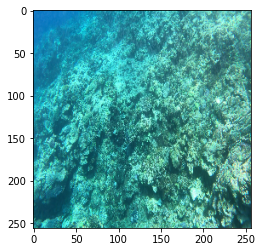

In [171]:
import matplotlib.pyplot as plt

sample = next(iter(train_ds))
plt.imshow(sample['image'][0])

### Object Flagging Dataset
- The constant shape image (256, 256)
- A gradient masking of the starfish using the annotations

In [172]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [173]:
# Assuming annotations are absolute
def from_annotations_to_gradient_mask(annotations, sigma, img_size=(720,1280), num_smooths=[0]):
    if len(annotations) == 0:
        return annotations
    # annotation - (xmin, ymin, width, height)
    mask = np.zeros(img_size, dtype=np.float32)
    for annotation in annotations:
        xmin, ymin, width, height = annotation
        mask[ymin:ymin+height, xmin:xmin+width] = 1.0

    grad_masks = []
    for i in range(num_smooths[0], num_smooths[-1]+1):
        if i in num_smooths:
            grad_masks.append(mask / mask.max())
        mask = gaussian_filter(mask, sigma=sigma)
    return grad_masks

In [174]:
abs_annotations_df

image_id
2-9675                                                    []
0-2121                                                    []
1-2194                                                    []
1-4453               [[644, 318, 32, 42], [325, 80, 44, 34]]
2-4243                                                    []
                                 ...                        
2-10390                                                   []
2-829                                                     []
2-305                                                     []
2-10703                                                   []
2-5772     [[623, 410, 55, 52], [637, 541, 55, 46], [734,...
Name: annotations, Length: 23501, dtype: object

In [175]:
smooth_cnts = [0, 4, 8, 16, 32, 64]
t_annotations = abs_annotations_df['2-5772']
t_img = cv2.imread("/content/starfish/train_images/video_2/5772.jpg") / 255.
t_grad_masks = from_annotations_to_gradient_mask(t_annotations, sigma=25.0, num_smooths=smooth_cnts)

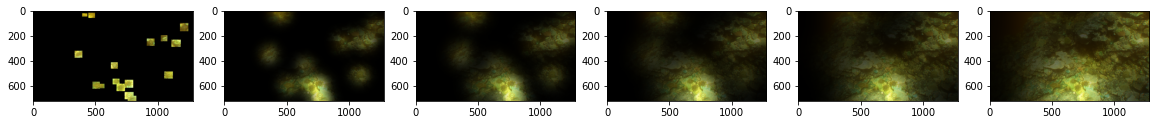

In [176]:
fig, axs = plt.subplots(1, len(smooth_cnts), figsize=(20,10)); axs = axs.flatten()
for ax,grad_mask in zip(axs, t_grad_masks):
    ax.imshow(t_img * grad_mask[..., np.newaxis])

In [177]:
# Use either the annotation bbox mask (smooth=0) or one of the earlier smooths as the target.
# Gradually feed (ie. train) the network images with wider FoV

# Final train_ds:
#   - img, tf.float32, rescaled to (256, 256), b/w [0.0, 1.0]
#       :: (256, 256, 3)
#   - set of gradient masks, tf.float32, b/w [0.0, 1.0], shape of (256, 256)
#       :: (# of grad masks, 256, 256)
#   - tar index corresponding to particular gradient mask

# Batched train_ds:
#   - img :: (bsz, 256, 256, 3)
#   - grad_masks :: (bsz, # of grad masks, 256, 256)
#   - tar_index :: (bsz,)

# During training:
#   - model can process each img w/ applied grad mask for an independent prediction
#   - preds :: (bsz, # of grad masks, 256, 256)
#   - tar :: grad_masks[bsz, 1, 256, 256] - each grad selected according to tar_index :: (bsz,)
#       - use gather/_nd?

In [178]:
# Make dataset of images that have annotations only
# - fs: /content/starfish/train_images

In [179]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

In [180]:
train_df = pd.read_csv('/content/starfish/train.csv')
train_df = train_df[train_df['annotations'].apply(lambda x: x != '[]')]
train_df['annotations'] = train_df['annotations'].apply(lambda x: json.loads(x.replace("'", '"')))
train_df['annotations'] = train_df['annotations'].apply(lambda x: np.array([list(y.values()) for y in x], dtype=np.int32))
train_df['filepath'] = "/content/starfish/train_images/video_" + train_df['video_id'].astype(str) + "/" + train_df['video_frame'].astype(str) + ".jpg"

In [181]:
train_df.sample()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filepath
7554,1,60510,846,846,1-846,"[[1058, 133, 77, 71]]",/content/starfish/train_images/video_1/846.jpg


#### Python Generator

In [182]:
# Assuming annotations are absolute
def apply_smooths_to_annotation_mask(annotations, sigma, img_size=(720,1280), num_smooths=0):
    if len(annotations) == 0:
        return annotations
    # annotation - (xmin, ymin, width, height)
    base_mask = np.zeros(img_size, dtype=np.float32)
    for annotation in annotations:
        xmin, ymin, width, height = annotation
        base_mask[ymin:ymin+height, xmin:xmin+width] = 1.0
    if num_smooths > 0:        
        mask = np.zeros(img_size, dtype=np.float32)
        for annotation in annotations:
            xmin, ymin, width, height = annotation
            expand_factor = 25*(num_smooths+1)
            mask[ymin-expand_factor:ymin+height+expand_factor, xmin-expand_factor:xmin+width+expand_factor] = 1.0
    else:
        mask = base_mask

    for i in range(num_smooths):
        mask = gaussian_filter(mask, sigma=sigma)
        if i > 5: # Crude cutoff to save on computations
            break
    mask_max = mask.max()
    if mask_max > 0: # Crude error catch - don't know source of error...
        smooth_mask = mask / mask.max()
    else:
         smooth_mask = np.ones(mask.shape)
    return base_mask, smooth_mask

In [230]:
def train_gen(focus_level=0, sigma=10.0, bsz=32):
    i = 0
    while i < bsz:
        sample = train_df.sample() # Randomly sample
        fpath = sample['filepath'].item()
        annotations = sample['annotations'].item()
    
        base_mask, smooth_mask = apply_smooths_to_annotation_mask(annotations, sigma=sigma,
                                                                img_size=(720, 1280),
                                                                num_smooths=focus_level)
        base_mask = tf.image.resize(base_mask[..., np.newaxis], [256, 256])
        smooth_mask = tf.image.resize(smooth_mask[..., np.newaxis], [256, 256])
    
        image = tf.io.read_file(fpath)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [256,256]) / 255.
        yield {'image': image, 'base_mask': base_mask, 'smooth_mask': smooth_mask}
    
output_types={'image': tf.float32,
              'base_mask': tf.float32,
              'smooth_mask': tf.float32}
output_shapes={'image': (256, 256, 3),
               'base_mask': (256, 256, 1),
               'smooth_mask': (256, 256, 1)}

In [236]:
focus_level = 10
sigma = 50.0
bsz = 32
train_gen_ds = Dataset.from_generator(train_gen, args=[focus_level, sigma, bsz],
                                      output_types=output_types,
                                      output_shapes=output_shapes)

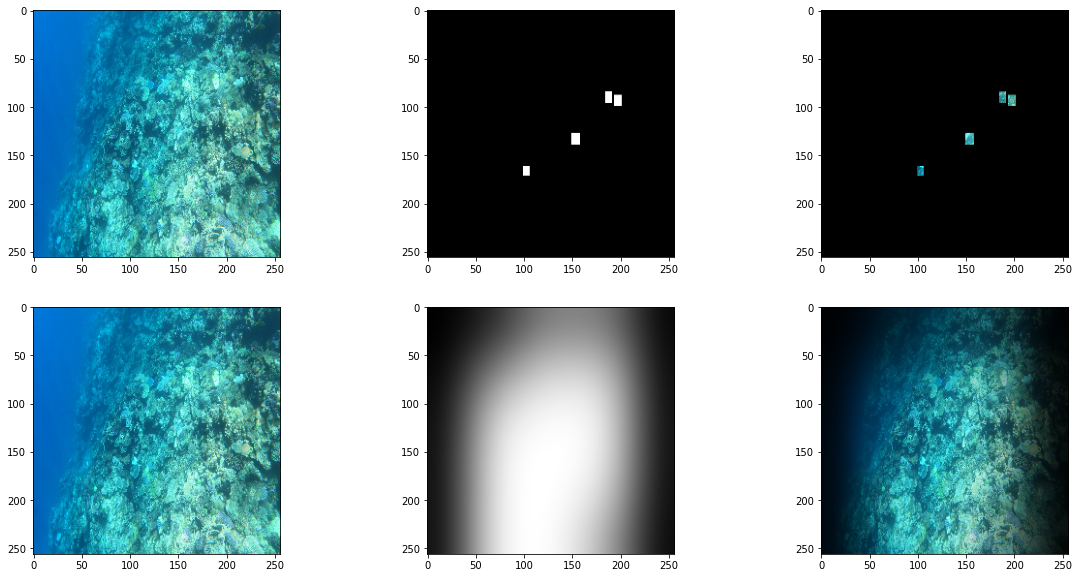

In [237]:
sample = next(iter(train_gen_ds))
base_mask = sample['base_mask']
smooth_mask = sample['smooth_mask']
image = sample['image']

fig, axs = plt.subplots(2,3, figsize=(20,10)); axs = axs.flatten()
axs[0].imshow(image)
axs[1].imshow(base_mask[..., 0], cmap='gray')
axs[2].imshow(image * base_mask)

axs[3].imshow(image)
axs[4].imshow(smooth_mask[..., 0], cmap='gray')
axs[5].imshow(image * smooth_mask)

In [186]:
# Good settings for now: expand_factor_constant = 25, sigma = 50.0, focus_level_cutoff = 5

#### End of Python Generator

# Model

In [240]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [241]:
# CNN
# In Image? or Not in Image?
# Push in side boundaries (relative %)
# Input - Image
# Output - In Image Flag? (Confidence)
# Output - % Change of respective boundary
# Loss - L2 Distance from True Boundary

In [242]:
basemodel = keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [243]:
class StarfishModel(keras.Model):
    def __init__(self, basemodel):
        super(StarfishModel, self).__init__()
        self.basemodel = basemodel # :: (None, None, None, 1280)
        self.globalpool2d = layers.GlobalAveragePooling2D() # :: (None, 1280)
        self.segmentlayer = layers.Dense(256*256, activation='sigmoid')
        self.reshapelayer = layers.Reshape((256,256,1))

    def call(self, image):
        features = self.basemodel(image)
        pooled_features = self.globalpool2d(features)
        segment_features = self.segmentlayer(pooled_features)
        segmentation_map = self.reshapelayer(segment_features)
        return segmentation_map

    def compile(self, optimizer):
        super(StarfishModel, self).compile()
        self.optimizer = optimizer

    @tf.function
    def train_step(self, sample):
        image = sample['image']
        base_mask = sample['base_mask']
        smooth_mask = sample['smooth_mask']
        
        with tf.GradientTape() as tape:
            segmentation_map = self.call(image * smooth_mask)
            loss = keras.losses.mse(base_mask, segmentation_map)
            loss = tf.reduce_mean(loss)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {'loss': loss}

In [244]:
model = StarfishModel(basemodel)
model.compile(keras.optimizers.Adam())

In [245]:
focus_level = 0
sigma = 50.0
bsz = 32
train_gen_ds = Dataset.from_generator(train_gen, args=[focus_level, sigma, bsz],
                                      output_types=output_types,
                                      output_shapes=output_shapes)
train_gen_ds = train_gen_ds.repeat().batch(bsz)
sample = next(iter(train_gen_ds))
print(sample['image'].shape, 
      sample['base_mask'].shape,
      sample['smooth_mask'].shape)

(32, 256, 256, 3) (32, 256, 256, 1) (32, 256, 256, 1)


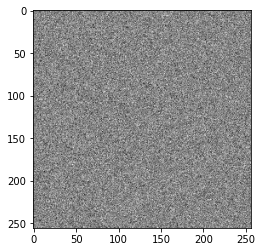

In [246]:
segmentation_map = model(sample['image'])
plt.imshow(segmentation_map[0, ..., 0], cmap='gray')

In [247]:
model.train_step(sample)

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.24994995>}

### Training

In [257]:
model = StarfishModel(basemodel)
model.compile(keras.optimizers.Adam())

In [258]:
sigma = 50.0
bsz = 32

In [ ]:
focus_levels = [0,1,2,3,4,5]
histories = []
for focus_level in focus_levels:
    train_gen_ds = Dataset.from_generator(train_gen, args=[focus_level, sigma, bsz],
                                          output_types=output_types,
                                          output_shapes=output_shapes)
    train_gen_ds = train_gen_ds.repeat().batch(bsz)
    history = model.fit(train_gen_ds, epochs=1,
                        steps_per_epoch=100)
    histories.append(history)